In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import random

In [4]:
data = pd.read_csv('data.csv', skiprows = [0, 1, 2, 4] ,encoding = 'shift-jis') #2012~17年の6年分のデータ
data.head()

,年月日,平均気温(℃),平均気温(℃).1,平均気温(℃).2
0,2012/1/1,4.2,8,1
1,2012/1/2,4.6,8,1
2,2012/1/3,5.2,8,1
3,2012/1/4,3.8,8,1
4,2012/1/5,3.9,8,1


In [5]:
data.tail()

,年月日,平均気温(℃),平均気温(℃).1,平均気温(℃).2
2187,2017/12/27,3.9,8,2
2188,2017/12/28,3.9,8,2
2189,2017/12/29,5.7,8,2
2190,2017/12/30,5.0,8,2
2191,2017/12/31,3.0,8,2


In [6]:
temp_data = data['平均気温(℃)']
temp_data

0       4.2
1       4.6
2       5.2
3       3.8
4       3.9
       ... 
2187    3.9
2188    3.9
2189    5.7
2190    5.0
2191    3.0
Name: 平均気温(℃), Length: 2192, dtype: float64

In [7]:
data[1820:1830] #365*5 = 1825

,年月日,平均気温(℃),平均気温(℃).1,平均気温(℃).2
1820,2016/12/25,5.6,8,2
1821,2016/12/26,5.3,8,2
1822,2016/12/27,8.2,8,2
1823,2016/12/28,5.2,8,2
1824,2016/12/29,3.3,8,2
1825,2016/12/30,5.4,8,2
1826,2016/12/31,5.2,8,2
1827,2017/1/1,6.8,8,2
1828,2017/1/2,6.4,8,2
1829,2017/1/3,7.4,8,2


In [8]:
train_x = temp_data[:1826] #平均気温5年分をtrain
test_x = temp_data[1826:] #1年分をtestに。
train_x = np.array(train_x)
test_x = np.array(test_x)

In [9]:
print(train_x)
print(len(train_x))

[4.2 4.6 5.2 ... 5.2 3.3 5.4]
1826


In [10]:
#ミニバッチようのデータを作る

window_size = 180 ##やっとwindowの意味がわかったかい？？
tmp = []
train_X = []

for i in range(0, len(train_x) - window_size): 
    tmp.append(train_x[i : i + window_size])

train_X = np.array(tmp)

In [19]:
pd.DataFrame(train_X) #1646個のミニバッチができました。

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,4.2,4.6,5.2,3.8,3.9,4.2,4.5,4.5,4.1,4.9,...,23.5,26.7,23.5,20.7,22.5,22.8,18.3,19.6,20.8,22.3
1,4.6,5.2,3.8,3.9,4.2,4.5,4.5,4.1,4.9,4.6,...,26.7,23.5,20.7,22.5,22.8,18.3,19.6,20.8,22.3,23.4
2,5.2,3.8,3.9,4.2,4.5,4.5,4.1,4.9,4.6,2.4,...,23.5,20.7,22.5,22.8,18.3,19.6,20.8,22.3,23.4,23.4
3,3.8,3.9,4.2,4.5,4.5,4.1,4.9,4.6,2.4,4.0,...,20.7,22.5,22.8,18.3,19.6,20.8,22.3,23.4,23.4,21.5
4,3.9,4.2,4.5,4.5,4.1,4.9,4.6,2.4,4.0,3.8,...,22.5,22.8,18.3,19.6,20.8,22.3,23.4,23.4,21.5,22.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641,21.6,23.5,25.8,26.9,30.2,28.2,21.6,23.6,27.7,25.5,...,3.6,5.4,7.0,9.6,9.0,9.2,12.7,13.0,7.8,5.6
1642,23.5,25.8,26.9,30.2,28.2,21.6,23.6,27.7,25.5,22.5,...,5.4,7.0,9.6,9.0,9.2,12.7,13.0,7.8,5.6,5.3
1643,25.8,26.9,30.2,28.2,21.6,23.6,27.7,25.5,22.5,26.2,...,7.0,9.6,9.0,9.2,12.7,13.0,7.8,5.6,5.3,8.2
1644,26.9,30.2,28.2,21.6,23.6,27.7,25.5,22.5,26.2,28.1,...,9.6,9.0,9.2,12.7,13.0,7.8,5.6,5.3,8.2,5.2


### モデルの定義

In [23]:
class Net(nn.Module):
    def __init__(self) :
        super(Net, self).__init__() 
        self.fc1 = nn.Linear(180, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 180)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = Net()

In [24]:
criterion = nn.MSELoss() #損失関数：平均二乗和誤差
optimizer = optim.Adam(model.parameters(), lr = 0.002) #勾配降下法の１つ。SGDやAdaGradなどの改良版。

for epoch in range(1000): #ミニバッチ学習を1000回学習を繰り返す
    total_loss = 0
    input_x = [] #変数の初期化
    
    for i in range(100):
        index = np.random.randint(0, 1645)  #1645個のミニバチからランダムに取り出す
        input_x.append(train_X[index]) #train_Xの中のランダムな行を抽出→input_xという空リストにappendしていく
        #これを100回繰り返すので、180日分の平均気温データが100個繋がった形になる。
    
    input_x = np.array(input_x, dtype = "float32") #numpyに変換
    input_x = Variable(torch.from_numpy(input_x))   #torch.tensorに変換し、勾配を維持するためにvariableとする
    
    optimizer.zero_grad()         #optimizerの初期化
    output = model(input_x)  #modelに、先ほど作った100個のデータを渡す
    
    loss = criterion(output, input_x)  #この２つの誤差を計算する
    loss.backward()  #この誤差を上流層に伝播する→微分値で各パラメーターを更新できる
    optimizer.step() ##ここまでで１周期
    
    total_loss += loss.item()  #計算した損失の値をtotal_lossに足し込んでいく
    
    if (epoch + 1) % 100 == 0:
        print(loss.item())
        print(epoch + 1, total_loss)  #100epochに1回、
        #途中経過を出してもらう。


nan
100 nan
nan
200 nan
nan
300 nan
nan
400 nan
nan
500 nan
nan
600 nan
nan
700 nan
nan
800 nan
nan
900 nan
nan
1000 nan


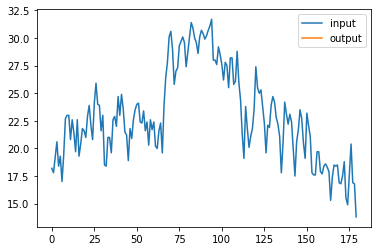

In [28]:
plt.plot(input_x.data[0].numpy(), label = 'input')
plt.plot(output.data[0].numpy(), label = 'output')
plt.legend(loc = "upper right") #凡例は右上に

### テストデータの出力を計算する

In [29]:
#異常値の検出

input_x =[]
test_X = []

input_x.append(test_x[0:180])
input_x.append(test_x[180:360])

test_X = np.array(input_x, dtype = "float32")

pd.DataFrame(test_X)



,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,5.2,6.800000,6.400000,7.400000,7.7,5.800000,3.8,3.000000,3.000000,7.6,...,23.5,23.4,22.1,24.1,24.9,24.799999,22.799999,23.9,23.299999,23.0
1,25.0,23.700001,23.299999,26.299999,29.1,26.799999,26.6,26.299999,27.200001,28.4,...,6.6,5.4,3.5,5.5,4.6,3.700000,4.100000,5.8,5.800000,8.4


In [30]:
input_test = Variable(torch.from_numpy(test_X))
output = model(input_test)

NameError: name 'outpput' is not defined

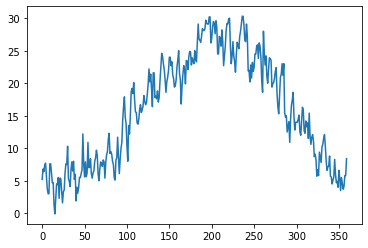

In [33]:
plt.plot(test_X.flatten(), label = "original")
plt.plot(output.data.numpy().flatten(), label = "predict")
plt.legend(loc = "upper right")